In [1]:
import numpy as np
import pandas as pd
import time
import random
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model

import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
env = gym.make("Breakout-v0")
init = env.reset()

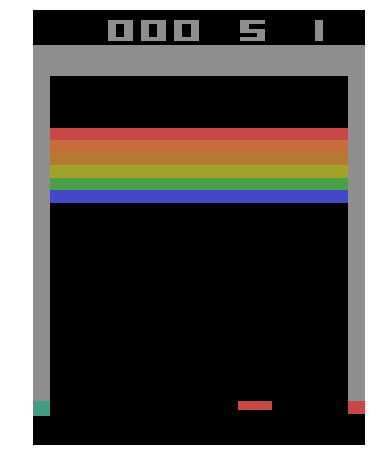

In [4]:
plot_state(init)

In [5]:
init = init.mean(axis=-1,keepdims=1)
init = init.astype('float32') / 255

In [6]:
init.shape

(210, 160, 1)

In [7]:
init[init > 0] = 1

In [8]:
init.max()

1.0

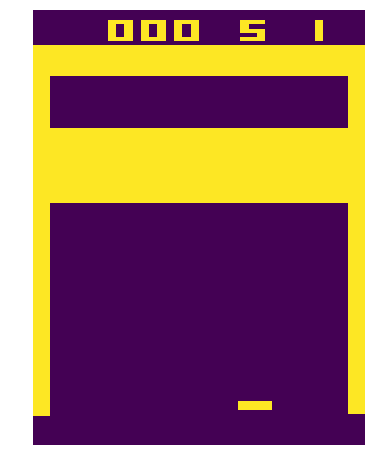

In [9]:
plot_state(init.reshape(210,160))

In [10]:
env.action_space

Discrete(4)

In [11]:
env.observation_space.shape

(210, 160, 3)

In [12]:
inp = Input(shape=init.shape)
x = Conv2D(8, (3,3), padding="same")(inp)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
output = Dense(3)(x)#env.action_space.n)(x)

model = Model(inp, output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mse"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 210, 160, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 210, 160, 8)       80        
_________________________________________________________________
flatten_1 (Flatten)          (None, 268800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               34406528  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 34,406,995
Trainable params: 34,406,995
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
def process_obs(obs):
    obs = obs.mean(axis=-1,keepdims=1)
    obs = obs.astype('float32') / 255
    obs[obs > 0] = 1
    obs = np.expand_dims(obs,0)
    return obs

In [ ]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation = process_obs(observation)


episodes = 100
epsilon = 0.9
gamma = 0.9
done = False

history = {}


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {}...\n".format(i))
    
    history = {"input":[], "reward":[], "action": [], "Q":[]}
    sum = 0
    game = True
    while game:
        
        rand = np.random.uniform(0,1)
        if  rand < epsilon:
            action = random.choice([1,2,3])#env.action_space.sample()
        else:
            action = np.argmax(model.predict(observation)) + 1
        #print(action)    
        observation, reward, done, info = env.step(action)
        
        observation = process_obs(observation)
        
        
        history["input"].append(observation)
        history["action"].append(action)
        history["reward"].append(reward)
        
        sum += reward

        time.sleep(0.001)
        env.render()
        
        if done:
        
            Q = []
            for j,k in enumerate(history["reward"][::-1]):
                if j == 0:
                    val = np.array([[0, 0, 0]])
                    val[0,history["action"][-1]-1] = k
                    Q.append(val)
                else:
                    val = np.array([[0, 0, 0]])
                    val[0,history["action"][-1-j]-1] = k + gamma*Q[-1][0].sum()
                    Q.append(val)
            
            Q = np.array(Q[::-1])
            Q = Q.reshape(Q.shape[0],Q.shape[2])


            history["Q"] = Q 
            
            print("Training the model...")
            
            history["input"] = np.array(history["input"])
            #print("shape: ",history["input"].shape)
            history["input"] = history["input"].reshape((history["input"].shape[0],\
                                                         history["input"].shape[2],\
                                                         history["input"].shape[3],\
                                                         history["input"].shape[4]))
            print(history["input"].shape)
            model.fit(history["input"], history["Q"], epochs = 1, batch_size=50)
            
            
            print("Total game score was: {}\n".format(sum))
            
            observation = env.reset()
            observation = process_obs(observation)
            epsilon -= 0.01
            game = False
                             
        else:
            pass
            
         

Welcome to AI Breakout!
Starting Game 1...

Training the model...
(297, 210, 160, 1)
Epoch 1/1
297/297 [==============================] - 7s 23ms/step - loss: 913.3839 - mean_squared_error: 913.3839
Total game score was: 2.0

Welcome to AI Breakout!
Starting Game 2...

Training the model...
(171, 210, 160, 1)
Epoch 1/1
171/171 [==============================] - 4s 25ms/step - loss: 30.1422 - mean_squared_error: 30.1422
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 3...

Training the model...
(207, 210, 160, 1)
Epoch 1/1
207/207 [==============================] - 6s 27ms/step - loss: 1.2470 - mean_squared_error: 1.2470
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 4...

Training the model...
(313, 210, 160, 1)
Epoch 1/1
313/313 [==============================] - 8s 25ms/step - loss: 2.4422 - mean_squared_error: 2.4422
Total game score was: 3.0

Welcome to AI Breakout!
Starting Game 5...

Training the model...
(168, 210, 160, 1)
Epoch 1/1
168/168 [==

In [ ]:
model.predict(observation)